In [1]:
class grow_crystal():
    """The growth of a crystal with dislocations.
    
    Parameter
    ---------
    dims : Tulple
        The dimensions of the crystal surface
    mu : float
        The dimensionless chemical potential
    T : float
        The dimensionless temperature
    set_migration : {True, False}
        If True surface migration is allowed
        If False surface migration is NOT allowed
    
    Return
    ------
    time : int
        The number of cycles (atom interactions)
    surface : nd.array
        The crystal surface at the last cycle
    N_surface : nd.array
        The crystal surface at different cycles
    neigh : nd.array
        The number of neighbours of all the atoms at the last cycle
    """

    def __init__(self, dims, mu, T, set_migration):
        self.T = T
        self.mu = mu
        self.dims = dims
        self.fx_matrix = np.zeros(dims)
        self.bx_matrix = np.zeros(dims)
        self.fy_matrix = np.zeros(dims)
        self.by_matrix = np.zeros(dims)
        self.num_dislocations = 0
        self.time = 0
        self.surface = np.ones(self.dims)
        self.N_surface = self.surface[:,:,np.newaxis]
        self.neigh = np.array([])
        self.set_migration = set_migration
    
    def dislocation_matrices(self, face, face_loc, boundaries, b):
        """Defining a dislocation line on the (001) cystal surface and create matrices to model
        the dislocations when the number of neighbouring atoms is determined.

        Parameter
        ---------
        face : int --> {0, 1}
            The plain the dislocation line is located in
            Value
            -----
            0 : dislocation line lies in the (100) plain
            1 : dislocation line lies in the (010) plain
        face_loc : int --> {1:dims[i]-1}
            The location of the plane the dislocation line lies in. For
            [face_loc] = n, the dislocation is between the (n-1)th and nth atom
        boundaries : Tulple --> [start, end]
        The boundaries of the dislocation line with [start] < [end]
            Value
            -----
            start : {0:dims[i]-1}
            end : {1:dims[i]}
        b : int
            The magnitude of the Burgers vector
            If b=0, there is no dislocation
            If b>0, the step will go up
            If b<0, the step will go down
        """
        
        line = np.arange(boundaries[0], boundaries[1], 1, dtype=int)
        dislocation_line = np.ones(boundaries[1]-boundaries[0])*b
        f_matrix = np.zeros(self.dims)
        b_matrix = np.zeros(self.dims)
        if face == 0:
            f_matrix[face_loc, line] = dislocation_line
            b_matrix[face_loc-1, line] = -dislocation_line
            self.fx_matrix += f_matrix
            self.bx_matrix += b_matrix
        elif face == 1:
            f_matrix[line, face_loc] = dislocation_line
            b_matrix[line, face_loc-1] = -dislocation_line
            self.fy_matrix += f_matrix
            self.by_matrix += b_matrix
        else:
            raise ValueWarning('Value for [face] should be either 0 or 1')
        self.num_dislocations += 1
        print('crystal surface with {} dislocations'.format(str(self.num_dislocations)))

    
    def num_dislocations(self):
        print('There are {} dislocations'.format(str(self.num_dislocations)))

        
    def migration(selft):
        if self.set_migration == True:
            print('Atoms are allowed to migrate')
        else:
            print('Atoms are not allowed to migrate')


    def scan_neighbours(self, surface, fx_neigh, fy_neigh, bx_neigh, by_neigh, loc):
        """Scanning how many neighbours an atom on the surface has.
        
        Parameter
        ---------
        surface : nd.array
            Crystal suface
        fx_neigh : nd.array
            Matrix used to create dislocation when looking at the forward neighbour in the x direction
        fy_neigh : nd.array
            Matrix used to create dislocation when looking at the forward neighbour in the y direction
        bx_neigh : nd.array
            Matrix used to create dislocation when looking at the backward neighbour in the x direction
        by_neigh : nd.array
            Matrix used to create dislocation when looking at the backward neighbour in the y direction
        loc : Tulple
            Coordinate of the atom
        
        Return
        ------
        n : int
            Number of neighbours of the atom at coordinate [loc]
        """
        
        dims = self.dims
        n = 1
        if surface[loc] <= fx_neigh[(loc[0]+1) % dims[0], loc[1] % dims[1]]:
            n += 1
        if surface[loc] <= fy_neigh[loc[0] % dims[0], (loc[1]+1) % dims[1]]:
            n += 1
        if surface[loc] <= bx_neigh[(loc[0]-1) % dims[0], loc[1] % dims[1]]:
            n += 1
        if surface[loc] <= by_neigh[loc[0] % dims[0], (loc[1]-1) % dims[1]]:
            n += 1
        return n


    def neighbours(self):
        """Identifying the number of neighbours of each surface atom using periodic boundary
        conditions for a surface with a single dislocation.
        
        Return
        ------
        neigh : nd.array
            Matrix with the number of neighboring atoms for every atom on the crystal surface
        """
        
        dims = self.dims
        neigh = np.zeros(dims)
        surface = self.surface
        fx_neigh = surface + self.fx_matrix
        bx_neigh = surface + self.bx_matrix
        fy_neigh = surface + self.fy_matrix
        by_neigh = surface + self.by_matrix
        for i in range(dims[0]):
            for j in range(dims[1]):
                loc = (i,j)
                n = self.scan_neighbours(surface, fx_neigh, fy_neigh, bx_neigh, by_neigh, loc)
                neigh[i,j] = n
        return neigh


    def evaporation_rate(self, n):
        """The evaporation rate of an atom based on the number of neighbours and temperature.
        
        Parameter
        ---------
        n : int
            Number of neighbours of an atom
        
        Return
        ------
        k_minus : float
            The evaporation rate of an atom
        """
        
        k_minus = np.exp(-n*self.T)
        return k_minus


    def impingement_rate(self):
        """The impingement rate of an atom based on the chemical potential and temperature.
        
        Return
        ------
        k_plus : float
            The impingement rate of an atom
        """
        
        k_3 = self.evaporation_rate(3)
        k_plus = np.exp(self.mu)*k_3
        return k_plus


    def nn_migration_rate(self, n):
        """The migration rate of an atom moving from a location of n neighbours to a location of 
        n neighbours. If migration is not allowed the migration rate is set to 0.
        
        Parameter
        ---------
        n : int
            The number of neighbours of the atom
        
        Return
        ------
        k_nn : float
            The migration rate
        """
        if self.set_migration == True:
            if n == 1:
                Esd = 1/2
            elif n == 2:
                Esd = 3/2
            else:
                Esd = 5/2
            k_nn = 1/8*np.exp(-Esd*self.T)
        else:
            k_nn = 0
        return k_nn
    
    def nm_migration_rate(self, loc_n, loc_m, neigh):
        """The migration rate for an atom moving from location [loc_n] to location [loc_m]. If
        migration is not allowed the migration rate is set to 0.
        
        Parameter
        ---------
        loc_n : Tulple
            The initial coordinate of the atom
        loc_m : Tulple
            The new coordinate of the atom
        neigh : nd.array
            The number of neighbours of all the atoms in the initial state of the crystal surface
        
        Return
        ------
        k_nm : float
            The migration rate between the two coordinates
        """
        if self.set_migration == True:
            n = neigh[loc_n]
            new_surface = self.surface
            new_surface[loc_n] += -1
            new_surface[loc_m] += 1
            fx_neighbour = new_surface + self.fx_matrix
            fy_neighbour = new_surface + self.fy_matrix
            bx_neighbour = new_surface + self.bx_matrix
            by_neighbour = new_surface + self.by_matrix
            m = self.scan_neighbours(new_surface, fx_neighbour, fy_neighbour, bx_neighbour, by_neighbour, loc_m)
            
            if n == 1 or m == 1:
                Esd = 1/2
            elif n == 2 or m == 2:
                Esd = 3/2
            else:
                Esd = 5/2

            if m <= n:
                DeltaE = n-m
            else:
                DeltaE = 0

            k_nm = 1/8*np.exp(-(Esd+DeltaE)*T)
        else:
            k_nm = 0
        return k_nm
    
    def choose_subset(self):
        """Choose a subset based on the number of neighbours an atom has.
        
        Return
        ------
        subset : int
            The number of neighbours all the atoms in the subset have
        """
        T = self.T
        mu = self.mu
        counts = dict(zip([1, 2, 3, 4, 5], [0, 0, 0, 0, 0]))
        if self.time == 0:
            first_neigh = self.neighbours()
            self.neigh = first_neigh
        neigh = self.neigh
        unique, counting = np.unique(neigh, return_counts = True)
        index = 0
        impingement_rate = self.impingement_rate()
        
        for number in unique:
            counts[number] = counting[index]
            index += 1

        denom = 0
        for i in range(1,6):
            denom += counts[i] * (self.evaporation_rate(i) + impingement_rate
                                  + self.nn_migration_rate(i))

        prob = np.zeros(5)
        for i in range(5):
            prob[i] = counts[i+1] * (self.evaporation_rate(i+1) + impingement_rate
                                     + self.nn_migration_rate(i+1)) / denom

        rand = uniform(0,1)
        if rand < prob[0]:
            subset = 1
        elif rand < prob[0] + prob[1]:
            subset = 2
        elif rand < prob[0] + prob[1] + prob[2]:
            subset = 3
        elif rand < prob[0] + prob[1] + prob[2] + prob[3]:
            subset = 4
        elif rand < prob[0] + prob[1] + prob[2] + +prob[3] + prob[4]:
            subset = 5
        
        return subset
    
    def interaction(self, dN):
        """Simulating an interaction at one location on the crystal surface. The interaction has 
        two possible outcomes if surface migration is not allowed:
        1. an atom evaporates from the surface
        2. there is an atom impingement
        The interaction has four possible outcomes if surface migration is allowed:
        1. an atom evaporates from the surface
        2. there is an atom impingement
        3. an atom migrates to a neighbouring location
        4. nothing happens the surface is unchanged
        
        Parameter
        ---------
        dN : int
            The number of cycles run between subsequent crystal surfaces stored in self.N_surface
        """
        dims = self.dims
        surface = self.surface
        change_surface = np.zeros(dims)
        subset = self.choose_subset()
        neigh = self.neigh
        options_x = np.where(neigh==subset)[0]
        options_y = np.where(neigh==subset)[1]
        site = choice(range(np.size(options_x)))

        location = (options_x[site], options_y[site])

        k_plus = self.impingement_rate()
        k_minus = self.evaporation_rate(subset)
        k_nn = self.nn_migration_rate(subset)

        denom = k_plus + k_minus + k_nn
        scan_loc_matrix = [(0,0), (0,-1), (0,1), (-1,0), (1,0)]
        change_neigh = np.zeros(dims)

        rand = uniform(0,1)
        if rand < k_plus/denom:
            change_surface[location] += 1
            new_surface = surface + change_surface
            for i in scan_loc_matrix: #create new neighbour matrix
                (location[0]+i[0], location[1]+i[1])
                scan_loc = ((location[0]+i[0]) % dims[0], (location[1]+i[1]) % dims[1])
                fx_neigh = new_surface + self.fx_matrix
                fy_neigh = new_surface + self.fy_matrix
                bx_neigh = new_surface + self.bx_matrix
                by_neigh = new_surface + self.by_matrix
                change_neigh[scan_loc] = self.scan_neighbours(new_surface, fx_neigh, 
                                                              fy_neigh, bx_neigh, 
                                                              by_neigh, scan_loc) - neigh[scan_loc]
            new_neigh = neigh + change_neigh
        elif rand < (k_plus+k_minus)/denom:
            change_surface[location] -= 1
            new_surface = surface + change_surface
            for i in scan_loc_matrix: #create new neighbour matrix
                scan_loc = ((location[0]+i[0]) % dims[0], (location[1]+i[1]) % dims[1])
                fx_neigh = new_surface + self.fx_matrix
                fy_neigh = new_surface + self.fy_matrix
                bx_neigh = new_surface + self.bx_matrix
                by_neigh = new_surface + self.by_matrix
                change_neigh[scan_loc] = self.scan_neighbours(new_surface, fx_neigh, 
                                                              fy_neigh, bx_neigh, 
                                                              by_neigh, scan_loc) - neigh[scan_loc]
            new_neigh = neigh + change_neigh
        else:
            options = [(1,1),(1,0),(1,-1),(0,1),(0,-1),(-1,1),(-1,0),(-1,-1)]
            migrate = choice(options)
            prob = self.nm_migration_rate(location, migrate, neigh)
            rand = uniform(0,1)
            if rand < prob:
                change_surface[location] -= 1
                change_surface[(location[0]+migrate[0]) % dims[0], (location[1]+migrate[1]) % dims[1]] +=1
                new_surface = surface + change_surface
                for i in scan_loc_matrix: #crate new neighbour matrix
                    scan_loc1 = ((location[0]+i[0]) % dims[0], (location[1]+i[1]) % dims[1])
                    scan_loc2 = ((migrate[0]+i[0]) % dims[0], (migrate[1]+i[1]) % dims[1])
                    fx_neigh = new_surface + self.fx_matrix
                    fy_neigh = new_surface + self.fy_matrix
                    bx_neigh = new_surface + self.bx_matrix
                    by_neigh = new_surface + self.by_matrix
                    change_neigh[scan_loc1] = self.scan_neighbours(new_surface, fx_neigh,
                                                                   fy_neigh, bx_neigh,
                                                                   by_neigh, scan_loc1) - neigh[scan_loc1]
                    change_neigh[scan_loc2] = self.scan_neighbours(new_surface, fx_neigh,
                                                                   fy_neigh, bx_neigh,
                                                                   by_neigh, scan_loc2) - neigh[scan_loc2]
                new_neigh = neigh + change_neigh
            else:
                new_surface = surface
                new_neigh = neigh
        self.surface = new_surface
        self.neigh = new_neigh
        self.time += 1
        if self.time % dN == 0: #If it stores too many surface matrices the kernal dies
            self.N_surface = np.append(self.N_surface, new_surface[:,:,np.newaxis], axis=2)

In [6]:
## Correct
import numpy as np
import matplotlib.pyplot as plt
from random import uniform, choice

dims = [80, 80]
T = 3.2 
Migration = False
Disloc = True

face = 0
face_loc = 40
boundaries = [0, 40]
b = 2

N = 100
dN = 10000

mu_min = 0
mu_max = 6
dmu = 0.5
mu = np.arange(mu_min, mu_max+dmu, dmu)

for mu_i in mu:
    crystal = grow_crystal(dims, mu_i, T, Migration)
    crystal.dislocation_matrices(face, face_loc, boundaries, b)
    for i in range(N):
        crystal.interaction(dN)
    # np.save('Simulation Data/Jeroen/mu={}_T={}_N={}'.format(mu_i, T, N), crystal.N_surface)




crystal surface with 1 dislocations
crystal surface with 1 dislocations
crystal surface with 1 dislocations
crystal surface with 1 dislocations
crystal surface with 1 dislocations
crystal surface with 1 dislocations
crystal surface with 1 dislocations
crystal surface with 1 dislocations
crystal surface with 1 dislocations
crystal surface with 1 dislocations
crystal surface with 1 dislocations
crystal surface with 1 dislocations
crystal surface with 1 dislocations


# Analysing data

In [4]:
import numpy as np
import matplotlib.pyplot as plt

mu = 1.5
T = 2
Migration = False
N = 1000000
b = 2
Disloc = True

crystal_surface = np.load('Project3_SangersJeroen_agefrancke_mwglorie/Simulation Data/Crystal_growth_mu={}_T={}_migration={}_N={}_b={}_dislocation={}_v1.npy'.format(str(mu), str(T), str(Migration), str(N), str(b), str(Disloc)))



FileNotFoundError: [Errno 2] No such file or directory: 'Project3_SangersJeroen_agefrancke_mwglorie/Simulation Data/Crystal_growth_mu=1.5_T=2_migration=False_N=10000_b=2_dislocation=True_v1.npy'

In [7]:
cycles = N
dims = crystal_surface.shape
N_atoms = dims[0] * dims[1]
sim_steps = dims[2]
cycle_steps = cycles/(dims[2]-1)
time_rate = cycle_steps*N_atoms
total_change = np.zeros(dims[2]-1)
growth_rate = np.zeros(dims[2]-1)
mean_hight = np.zeros(dims[2]-1)
for i in range(sim_steps-1):
    init_surface = crystal_surface[:,:,i]
    final_surface = crystal_surface[:,:,i+1]
    mean_hight[i] = np.sum(np.sum(final_surface, axis=0))/N_atoms
    surface_change = final_surface - init_surface
    total_change[i] = np.sum(np.sum(surface_change, axis=0))
    growth_rate[i] = total_change[i]/time_rate

NameError: name 'crystal_surface' is not defined

In [8]:
xr, yr = crystal_surface[:,:,-1].shape
x, y = np.arange(xr+1), np.arange(yr+1)

plt.figure(figsize=[12,6])
plt.pcolor(x, y, crystal_surface[:,:,-1])
plt.gca().set_aspect('equal')
plt.title("Surface deposition height")
plt.xlabel(r"x")
plt.ylabel(r"y")
plt.colorbar()

NameError: name 'crystal_surface' is not defined

In [9]:
plt.figure(figsize=[12,6])
plt.plot(growth_rate)
plt.grid()
plt.show()

NameError: name 'growth_rate' is not defined

<Figure size 864x432 with 0 Axes>

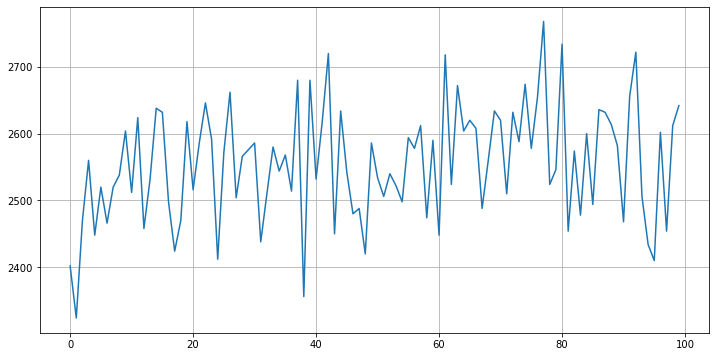

In [ ]:
plt.figure(figsize=[12,6])
plt.plot(total_change)
plt.grid()
plt.show()

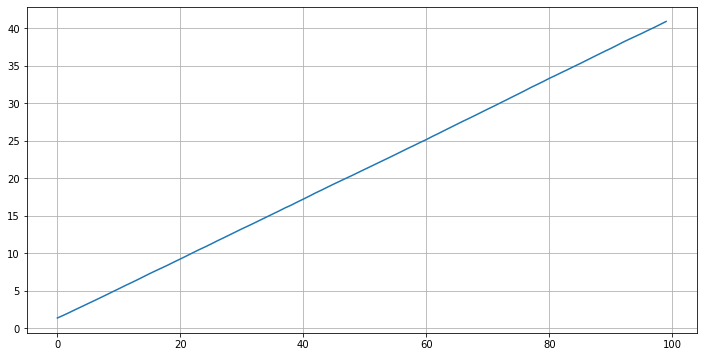

In [ ]:
plt.figure(figsize=[12,6])
plt.plot(mean_hight)
plt.grid()
plt.show()

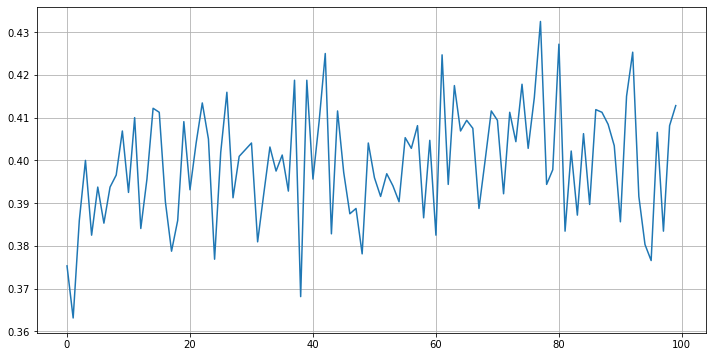

In [ ]:
m_heigh = np.append([1], [mean_hight])
plt.figure(figsize=[12,6])
plt.plot(m_heigh[1:]-m_heigh[:-1])
plt.grid()
plt.show()